In [1]:
!git clone https://github.com/Coeze/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 667, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 667 (delta 70), reused 39 (delta 39), pack-reused 573 (from 1)
Receiving objects: 100% (667/667), 19.59 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (382/382), done.


In [2]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


In [3]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap noise scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.0 MB/s eta 0:00:00
  Created wheel for noise: filename=noise-1.2.2-cp311-cp311-linux_x86_64.whl size=56278 sha256=f4021b6561760fe820209ac9e4be7eb8d28978c7672a3de61424a2f4fe4da614
  Stored in directory: /root/.cache/pip/wheels/39/25/2e/af6d1bcc91a8f99af0f651f8718b9ab999720a21c6d4149091
Successfully built noise


In [4]:
from src.bayes_optimisation import BayesianParameterEstimation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.model import CA

from noise import snoise2
import json

In [6]:
# Load the real Pine Hollow fire data
fire = "arizona"
grid_size = (250,250)

In [7]:
def generate_terrain_simplex(rows, cols, cell_size=30.0, min_elevation=100, max_elevation=1000,
                           octaves=6, persistence=0.5, lacunarity=2.0, scale=100.0, seed=None):
    """
    Generate realistic terrain elevation, slope, and aspect using Simplex noise.

    Parameters:
    - rows, cols: Dimensions of the grid
    - cell_size: size of each cell in meters
    - min_elevation, max_elevation: Range of elevation values in meters
    - octaves: Number of noise layers to combine (more = more detail)
    - persistence: How much each octave contributes (amplitude multiplier)
    - lacunarity: How frequency increases with each octave
    - scale: Base scale of the noise (higher = more gradual changes)
    - seed: Random seed for reproducibility

    Returns:
    - elevation: 2D numpy array of elevation values
    - slope: 2D numpy array of slope values in degrees
    - aspect: 2D numpy array of aspect values in degrees (0-360, 0=North)
    """

    if seed is not None:
        np.random.seed(seed)

    # Generate elevation using simplex noise
    elevation = np.zeros((rows, cols))

    # For better performance, vectorise the coordinates
    y_coords = np.linspace(0, scale, rows)
    x_coords = np.linspace(0, scale, cols)

    for octave in range(octaves):
        frequency = lacunarity ** octave
        amplitude = persistence ** octave

        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                elevation[i, j] += amplitude * snoise2(
                    y * frequency / scale,
                    x * frequency / scale
                )

    # Normalise to 0-1 range
    elevation_min = elevation.min()
    elevation_max = elevation.max()
    elevation = (elevation - elevation_min) / (elevation_max - elevation_min)

    # Scale to desired elevation range
    elevation = min_elevation + elevation * (max_elevation - min_elevation)

    # Calculate slope and aspect from elevation using gradients
    dy, dx = np.gradient(elevation, cell_size, cell_size)

    # Calculate slope in degrees
    # Slope is the angle of steepest descent
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Calculate aspect in degrees (0-360, clockwise from north)
    # Aspect is the direction of steepest descent
    aspect = np.degrees(np.arctan2(-dx, dy))
    # Convert to 0-360 range (0 = North)
    aspect = np.where(aspect < 0, aspect + 360, aspect)

    return elevation, slope, aspect

# Generate terrain using simplex noise instead of random values
elevation, slope, aspect = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=100,
    max_elevation=1000,
    scale=100.0,
    seed=42
)

In [8]:
estimator = BayesianParameterEstimation(elevation=elevation, slope=slope, aspect=aspect, fire_name=fire, grid_size=grid_size)

In [9]:
best_params, results_df = estimator.run_sequential_monte_carlo()

SMC Step 1/5


  0%|          | 0/10 [00:00<?, ?it/s]

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Updated environmental conditions:
  Wind speed: 4.94 m/s
  Wind direction: 88.83°
  Temperature: 84.97°F
  humidity: 20.32
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.95 m/s
  Wind direction: 88.53°
  Temperature: 84.80°F
  humidity: 20.32
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.79 m/s
  Wind direction: 92.67°
  Temperature: 84.90°F
  humidity: 20.42
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.74 m/s
  Wind direction: 91.45°
  Temperature: 84.72°F
  humidity: 20.58
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.7

  0%|          | 0/10 [00:00<?, ?it/s]

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Updated environmental conditions:
  Wind speed: 4.62 m/s
  Wind direction: 91.85°
  Temperature: 84.91°F
  humidity: 20.03
  Precipitation: 0.13 mm
Updated environmental conditions:
  Wind speed: 4.66 m/s
  Wind direction: 91.19°
  Temperature: 84.79°F
  humidity: 20.04
  Precipitation: 0.12 mm
Updated environmental conditions:
  Wind speed: 4.89 m/s
  Wind direction: 91.51°
  Temperature: 85.03°F
  humidity: 20.08
  Precipitation: 0.07 mm
Updated environmental conditions:
  Wind speed: 4.99 m/s
  Wind direction: 92.68°
  Temperature: 84.70°F
  humidity: 19.97
  Precipitation: 0.15 mm
Updated environmental conditions:
  Wind speed: 5.0

  0%|          | 0/10 [00:00<?, ?it/s]

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Updated environmental conditions:
  Wind speed: 4.73 m/s
  Wind direction: 91.03°
  Temperature: 85.38°F
  humidity: 20.23
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.83 m/s
  Wind direction: 88.28°
  Temperature: 85.37°F
  humidity: 20.14
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.83 m/s
  Wind direction: 88.41°
  Temperature: 85.46°F
  humidity: 19.92
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.76 m/s
  Wind direction: 86.10°
  Temperature: 85.44°F
  humidity: 19.66
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.6

  0%|          | 0/10 [00:00<?, ?it/s]

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Updated environmental conditions:
  Wind speed: 4.92 m/s
  Wind direction: 88.09°
  Temperature: 85.20°F
  humidity: 20.32
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.80 m/s
  Wind direction: 91.63°
  Temperature: 85.08°F
  humidity: 20.29
  Precipitation: 0.00 mm
Updated environmental conditions:
  Wind speed: 4.78 m/s
  Wind direction: 88.74°
  Temperature: 85.05°F
  humidity: 20.31
  Precipitation: 0.05 mm
Updated environmental conditions:
  Wind speed: 4.75 m/s
  Wind direction: 88.85°
  Temperature: 84.71°F
  humidity: 20.19
  Precipitation: 0.13 mm
Updated environmental conditions:
  Wind speed: 4.4

  0%|          | 0/10 [00:00<?, ?it/s]

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Updated environmental conditions:
  Wind speed: 5.03 m/s
  Wind direction: 92.82°
  Temperature: 85.16°F
  humidity: 19.80
  Precipitation: 0.02 mm
Updated environmental conditions:
  Wind speed: 5.17 m/s
  Wind direction: 93.23°
  Temperature: 85.40°F
  humidity: 19.71
  Precipitation: 0.10 mm
Updated environmental conditions:
  Wind speed: 5.29 m/s
  Wind direction: 95.54°
  Temperature: 85.00°F
  humidity: 19.63
  Precipitation: 0.09 mm
Updated environmental conditions:
  Wind speed: 5.40 m/s
  Wind direction: 96.99°
  Temperature: 85.30°F
  humidity: 19.45
  Precipitation: 0.04 mm
Updated environmental conditions:
  Wind speed: 5.3

In [10]:
best_params

{'c1': np.float64(0.9449364652782473),
 'c2': np.float64(0.3653724123517157),
 'p0': np.float64(0.6325668822180583),
 'p1': np.float64(0.12672398025670942),
 'p2': np.float64(0.14816467220742166)}

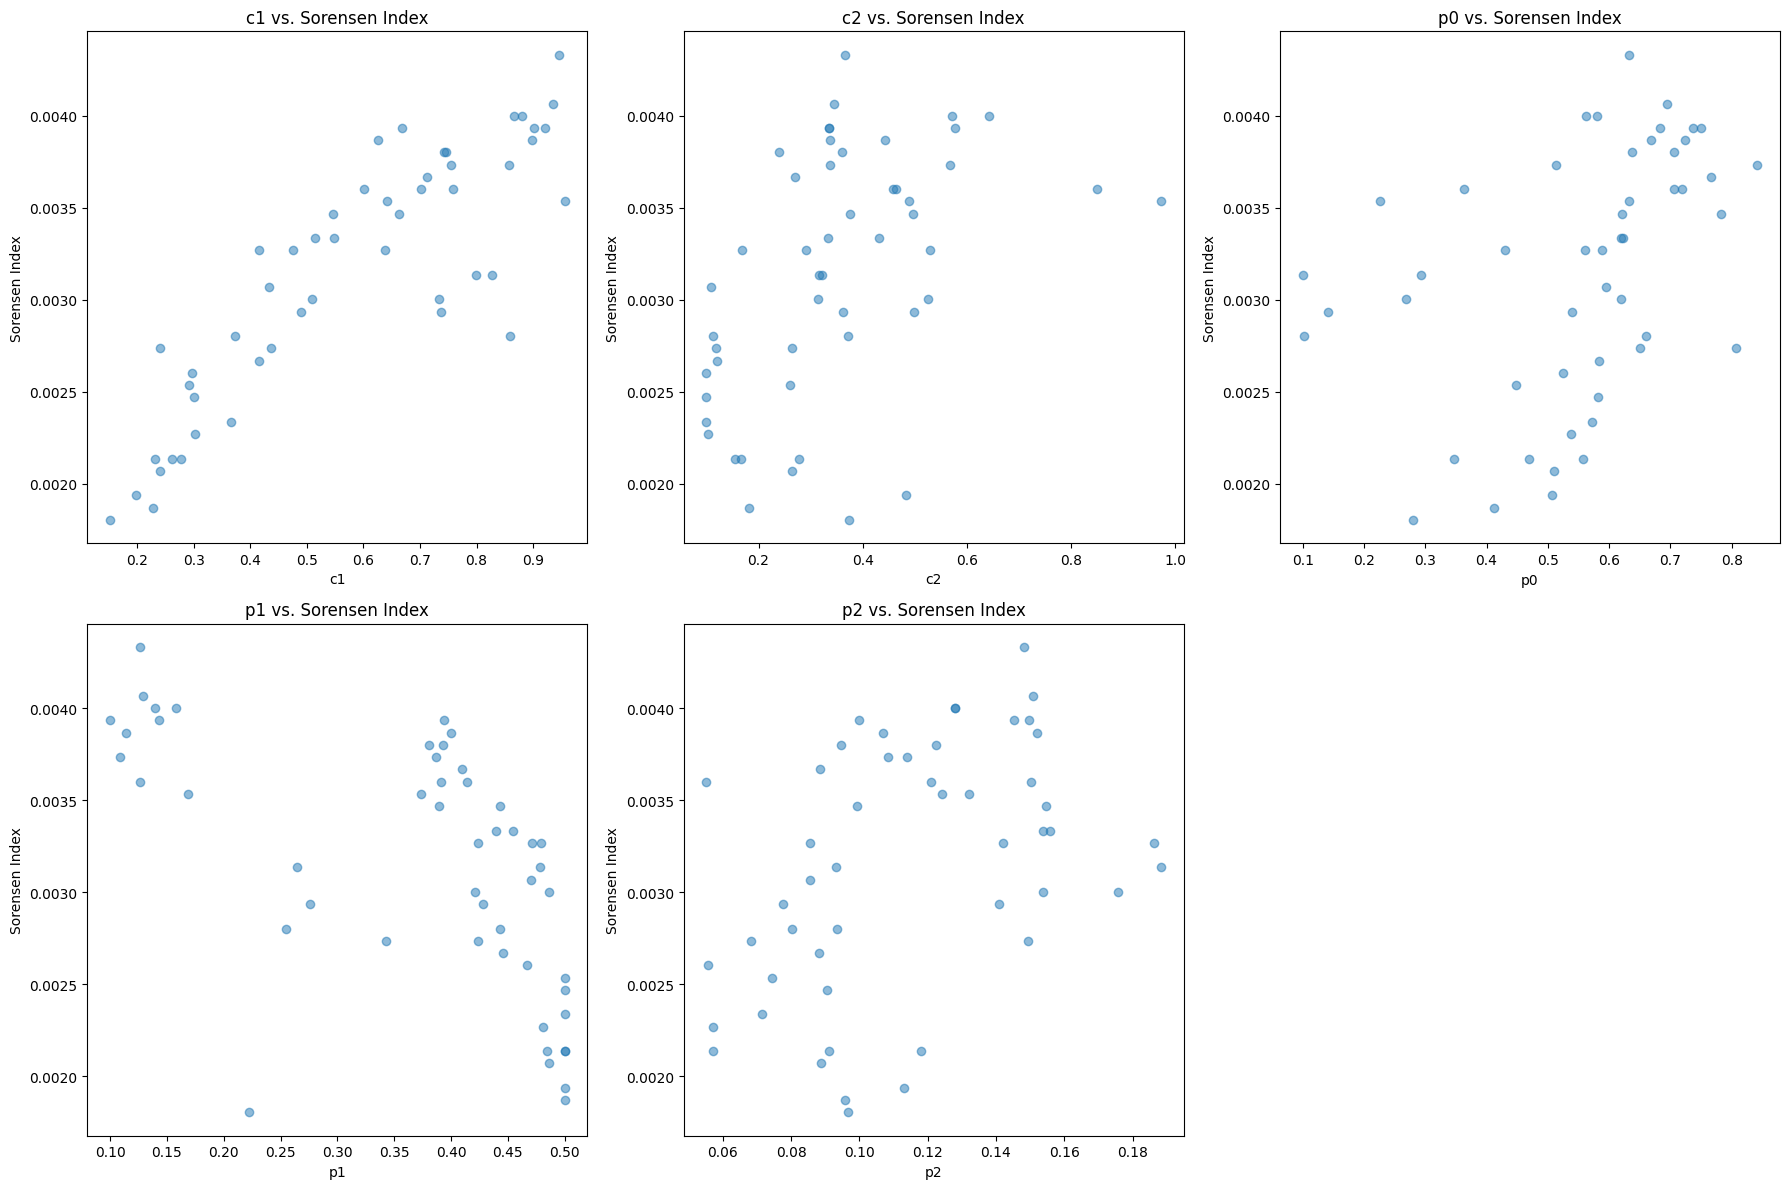

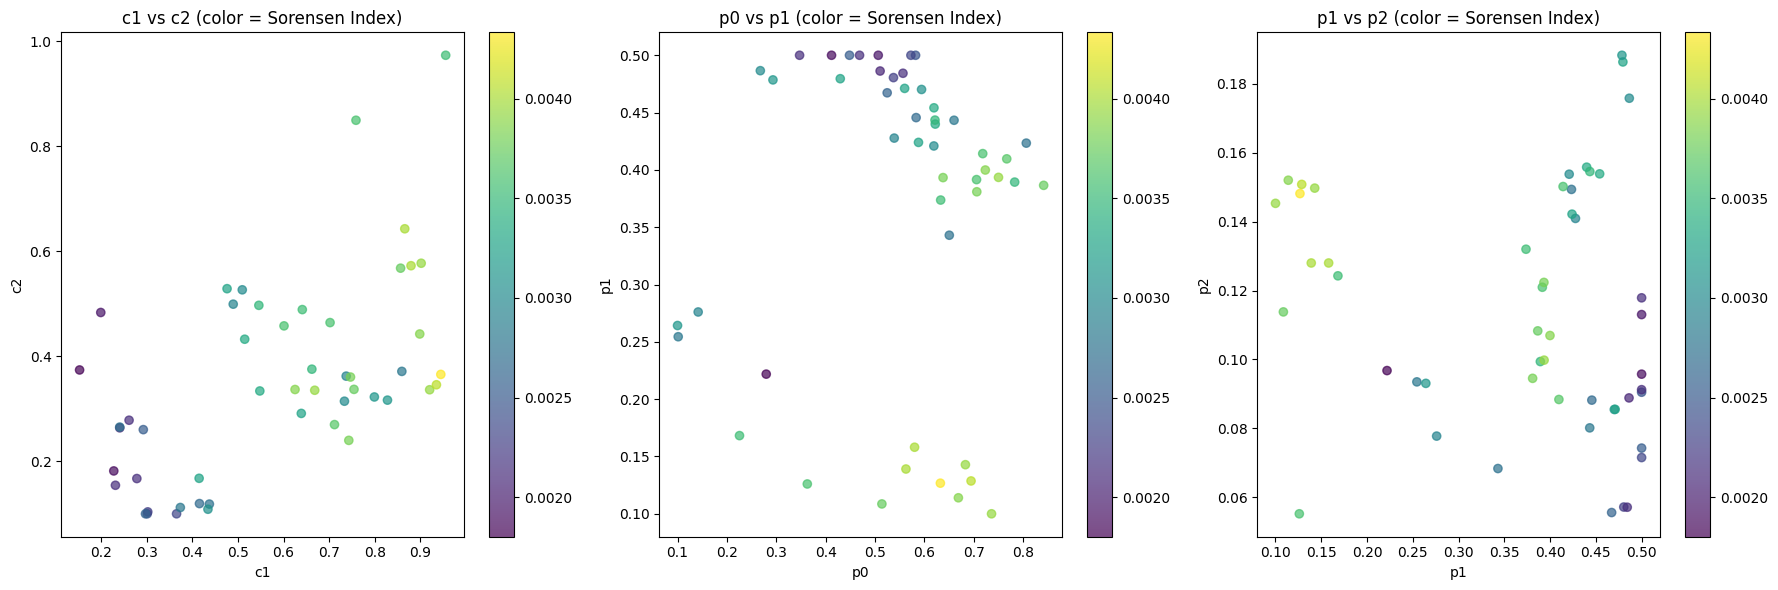

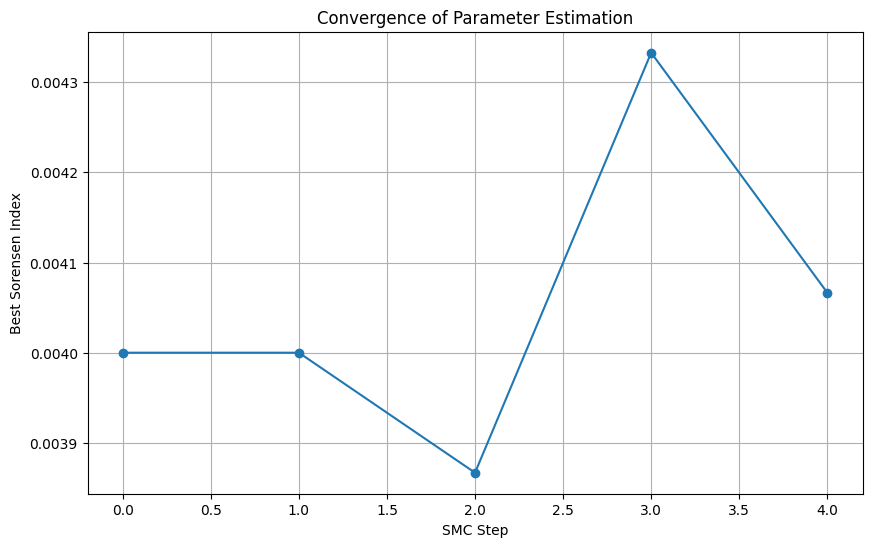

In [11]:
estimator.visualize_results(results_df)